In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import Sheet, Monolayer, config

from tyssue.topology.monolayer_topology import cell_division

from tyssue import ClosedMonolayerGeometry as geom
from tyssue.solvers import QSSolver
from tyssue.generation import extrude


from tyssue.dynamics import effectors, model_factory

from tyssue.draw import sheet_view

from tyssue.io.hdf5 import save_datasets, load_datasets



In [2]:
datasets = load_datasets('../data/hf5/small_ellipsoid.hf5')
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)
monolayer.reset_index()
monolayer.reset_topo()
geom.update_all(monolayer)


# ## Settings for the quasi-static model
model = model_factory([effectors.LumenVolumeElasticity,
                       effectors.CellVolumeElasticity,
                       effectors.CellAreaElasticity,
                       effectors.LineTension],
                      effectors.CellVolumeElasticity)

## Initial model settings
dyn_specs = {
    "settings": {
        "lumen_side": "basal",
        "lumen_prefered_vol": monolayer.settings["lumen_vol"],
        "lumen_vol_elasticity": 10.0,
        "threshold_length": 1e-2,
    },
    "cell": {
        "prefered_vol": monolayer.cell_df.vol.mean(),
        "prefered_area": monolayer.cell_df.area.mean(),        
        "vol_elasticity": 1.0,
        "area_elasticity": 1.0,
    },
    "edge": {
        "line_tension": 0.01,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    }
}

monolayer.update_specs(dyn_specs)



In [3]:
def test_spherical_grad():
    sheet = generation.ellipsoid_sheet(1, 1, 1, 10)
    sheet.settings["geometry"] = "spherical"
    np.testing.assert_approx_equal(
        np.linalg.norm(height_grad(sheet), axis=1).mean(), 2, 2
    )

In [4]:
from tyssue import generation
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.geometry.sheet_geometry import EllipsoidGeometry

In [5]:
sheet = generation.ellipsoid_sheet(1, 1, 1, 10)
sheet.settings["geometry"] = "spherical"
EllipsoidGeometry.update_all(sheet)
np.testing.assert_approx_equal(
    np.linalg.norm(height_grad(sheet), axis=1).mean(), 1, 2
)

In [8]:
monolayer.settings

{'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_vol': 0.29248877463090095,
 'lumen_side': 'basal',
 'lumen_prefered_vol': 0.29248877463090095,
 'lumen_vol_elasticity': 10.0,
 'threshold_length': 0.01}

In [9]:
monolayer.settings['lumen_side'] = "basal"
geom.update_all(monolayer)

In [10]:
monolayer.settings["lumen_vol"]

0.29248877463090095

In [11]:
energies = model.compute_energy(monolayer, full_output=True)
print(*(f"{label.ljust(25)}: \t{np.sum(energy)/monolayer.Nc:.3e}"
      for label, energy in zip(model.labels, energies)), sep='\n')


Lumen volume elasticity  : 	0.000e+00
Volume elasticity        : 	4.448e-01
Area elasticity          : 	7.713e-03
Line tension             : 	1.803e-01


In [24]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)
res = solver.find_energy_min(monolayer, geom, model)

In [25]:
print(res["message"])

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [26]:
def two_panels(monolayer):

    fig, (xy, zy) = plt.subplots(1, 2, sharey=True)
    fig, xy = sheet_view(monolayer, mode="quick",
                         coords=['x', 'y'],
                         ax=xy, c='k', alpha=0.3)
    fig, zy = sheet_view(monolayer, mode="quick", 
                         coords=['z', 'y'],
                         ax=zy, c='k', alpha=0.3)
    fig.set_size_inches(12, 6)
    return fig

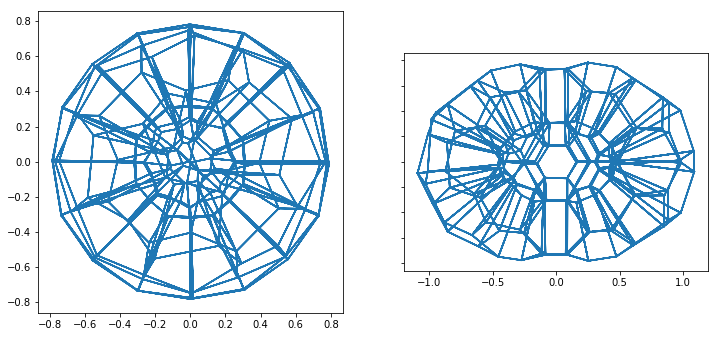

In [27]:
fig = two_panels(monolayer)

In [28]:
monolayer.face_df['visible'] = False
monolayer.face_df.loc[monolayer.basal_faces, "visible"] = True
ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D", face={"visible": True})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [29]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [30]:
mother = 10
daughter = cell_division(monolayer, mother, orientation='vertical')


res = solver.find_energy_min(monolayer, geom, model)


In [31]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [33]:
monolayer.face_df['visible'] = False
monolayer.face_df.loc[monolayer.basal_faces, "visible"] = True
monolayer.face_df.loc[mother, "visible"] = True

ipv.clear()
fig, mesh = sheet_view(monolayer, mode="3D", face={"visible": True})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

Failed for cell 4
Failed for cell 14
Failed for cell 34
Failed for cell 41
Failed for cell 42
Failed for cell 43
Failed for cell 44
Failed for cell 47


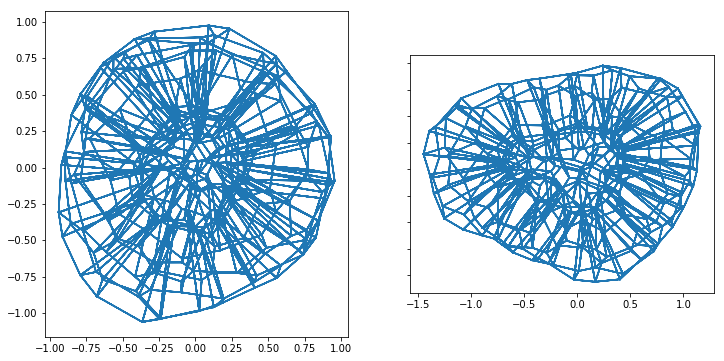

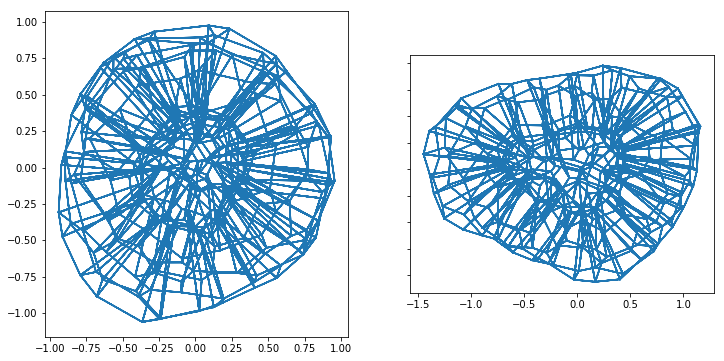

In [34]:
for cell in monolayer.cell_df.index:
    try:
        daughter = cell_division(monolayer, cell,
                                 orientation='vertical')
        res = solver.find_energy_min(monolayer, geom, model)
    except ValueError as e:
        print('Failed for cell {}'.format(cell))
        continue

monolayer.reset_index()
monolayer.reset_topo()
two_panels(monolayer)

In [22]:
from tyssue.io import obj

In [67]:
for i in range(5):
    
    monolayer.cell_df['prefered_area'] *= 1.2
    res = solver.find_energy_min(monolayer, geom, model)


In [68]:
1.2**10

6.191736422399997

In [35]:
ipv.clear()
monolayer.face_df["visible"] = True
monolayer.face_df.loc[monolayer.apical_faces, "visible"] = False

fig, mesh = sheet_view(monolayer, mode="3D",
                       face={"visible": True, "color": monolayer.face_df['area']*0.8})

fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [70]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'